In [1]:
# Cameron Schultz 
# ckschult@usc.edu
# Github: ckschultz

In [5]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats import outliers_influence
from statsmodels.stats.outliers_influence import OLSInfluence
import seaborn as sb
import sklearn
from sklearn import neighbors 
from sklearn.neighbors import KNeighborsRegressor, DistanceMetric
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split
# from sklearn import metrics
from sklearn.utils import shuffle 
# from sklearn.metrics import classification_report, confusion_matrix, precision_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

**b) EXPLORING THE DATA**

**i)**

In [6]:
path = '../data/Folds5x2_pp.xlsx'

df = pd.read_excel(path, names=['AmbientTemperature_AT', 'ExhaustVacuum_V', 'AmbientPressure_AP', 'RelativeHumidity_RH'
                               , 'ElectEnergyOutput_EP']) 

cols = df.shape[0]
rows = df.shape[1]

print("Number of rows:", rows)
print("Number of columns:", cols)
print("Rows represent the number of observations taken. Each row is a unique observation or data point.\nColumns \
represent the number of independent variables. Each column is a unique independent variable.")


Number of rows: 5
Number of columns: 9568
Rows represent the number of observations taken. Each row is a unique observation or data point.
Columns represent the number of independent variables. Each column is a unique independent variable.


In [4]:
df

,AmbientTemperature_AT,ExhaustVacuum_V,AmbientPressure_AP,RelativeHumidity_RH,ElectEnergyOutput_EP
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90
...,...,...,...,...,...
9563,16.65,49.69,1014.01,91.00,460.03
9564,13.19,39.18,1023.67,66.78,469.62
9565,31.32,74.33,1012.92,36.48,429.57
9566,24.48,69.45,1013.86,62.39,435.74


**ii) PAIRWISE SCATTER PLOTS & DESCRIBE FINDINGS**

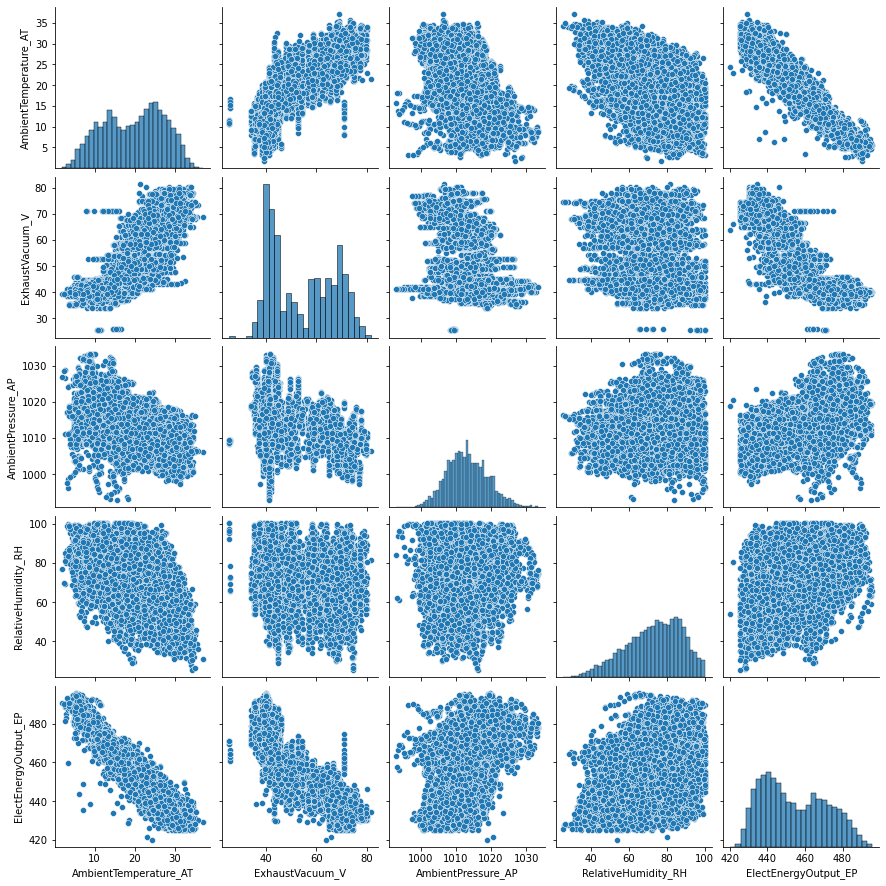

In [5]:
crossplot = sb.pairplot(df)
plt.show(crossplot)

**FINDINGS**
In the above plot, we can see the influence of each of the independent variables on each other, as well as each of the 
independent variables on the dependent variable (Electrical Energy Output of the Plant). 
Some observations include:
 - Ambient temperature and EP have a fairly strong negative correlation; as temperatures increase, EP tends to decrease.
 - Exhaust Vacuum is also negatively correlated with electrical energy output. Higher exhaust vacuum rates are more often associated with lower electrical energy outputs, while lower V rates tend to have higher energy outputs. 
 - Relative humidity and EP have a somewhat positive correlation. Higher relative humidity is asociated with a higher electrical energy output, and it is less common for high energy output to be achieved at low humidity rates. Not very strongly correlated. 
 - Higher ambient pressure tends to be associated with higher energy outputs, while lower ambient pressure can be associated with a range of energy outputs. Not very strongly correlated. 

**iii) Summary Statistics**

In [7]:
d = {
    'mean': [df['AmbientTemperature_AT'].mean(), df['ExhaustVacuum_V'].mean(), df['AmbientPressure_AP'].mean()
            , df['RelativeHumidity_RH'].mean(), df['ElectEnergyOutput_EP'].mean()], 
    'median': [df['AmbientTemperature_AT'].median(), df['ExhaustVacuum_V'].median(), df['AmbientPressure_AP'].median()
            , df['RelativeHumidity_RH'].median(), df['ElectEnergyOutput_EP'].median()], 
    'range': [df['AmbientTemperature_AT'].max() - df['AmbientTemperature_AT'].min(), 
              df['ExhaustVacuum_V'].max()- df['ExhaustVacuum_V'].min(), 
              df['AmbientPressure_AP'].max()-df['AmbientPressure_AP'].min(),
              df['RelativeHumidity_RH'].max() - df['RelativeHumidity_RH'].min(), 
              df['ElectEnergyOutput_EP'].max() - df['ElectEnergyOutput_EP'].min()], 
    'firstQuartile': [df['AmbientTemperature_AT'].quantile(q=0.25), df['ExhaustVacuum_V'].quantile(q=0.25),
                      df['AmbientPressure_AP'].quantile(q=0.25),
                      df['RelativeHumidity_RH'].quantile(q=0.25), df['ElectEnergyOutput_EP'].quantile(q=0.25)], 
    'thirdQuartile': [df['AmbientTemperature_AT'].quantile(q=0.75), df['ExhaustVacuum_V'].quantile(q=0.75),
                      df['AmbientPressure_AP'].quantile(q=0.75),
                      df['RelativeHumidity_RH'].quantile(q=0.75), df['ElectEnergyOutput_EP'].quantile(q=0.75)],
    'interquartileRange': [df['AmbientTemperature_AT'].quantile(q=0.75)-df['AmbientTemperature_AT'].quantile(q=0.25),
                           df['ExhaustVacuum_V'].quantile(q=0.75) - df['ExhaustVacuum_V'].quantile(q=0.25),
                           df['AmbientPressure_AP'].quantile(q=0.75)- df['AmbientPressure_AP'].quantile(q=0.25),
                           df['RelativeHumidity_RH'].quantile(q=0.75) - df['RelativeHumidity_RH'].quantile(q=0.25),
                           df['ElectEnergyOutput_EP'].quantile(q=0.75) - df['ElectEnergyOutput_EP'].quantile(q=0.25)]
    
}
table = pd.DataFrame(d, ['AmbientTemperature_AT', 'ExhaustVacuum_V', 'AmbientPressure_AP',
                         'RelativeHumidity_RH', 'ElectEnergyOutput_EP'], 
                     ['mean', 'median', 'range', 'firstQuartile', 'thirdQuartile', 'interquartileRange'])
table


,mean,median,range,firstQuartile,thirdQuartile,interquartileRange
AmbientTemperature_AT,19.651231,20.345,35.30,13.5100,25.72,12.2100
ExhaustVacuum_V,54.305804,52.080,56.20,41.7400,66.54,24.8000
AmbientPressure_AP,1013.259078,1012.940,40.41,1009.1000,1017.26,8.1600
RelativeHumidity_RH,73.308978,74.975,74.60,63.3275,84.83,21.5025
ElectEnergyOutput_EP,454.365009,451.550,75.50,439.7500,468.43,28.6800


**C)**

**ESTABLISHING REGRESSION DATA**

In [8]:
at = df['AmbientTemperature_AT'].to_numpy().reshape(-1, 1)
v = df['ExhaustVacuum_V'].to_numpy().reshape(-1, 1)
ap = df['AmbientPressure_AP'].to_numpy().reshape(-1, 1)
rh = df['RelativeHumidity_RH'].to_numpy().reshape(-1, 1)
ep = df['ElectEnergyOutput_EP'].to_numpy().reshape(-1, 1)


**REGRESSIONS**

**Ambient Temperature**

In [2]:
# regression + scatter plot: 
def ols_regression_plot(x, y, xlabel, ylabel):
    reg = LinearRegression()
    reg.fit(x, y)
    y_predictions = reg.predict(x)
    
    # create plots
    plt.scatter(x, y)
    plt.plot(x, y_predictions, color='red')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(xlabel + ' vs ' + ylabel)
    plt.show()
    
def cooks_outlier_plot(reg, x, xlabel):
    inf = reg.get_influence()
    cooks = inf.cooks_distance
    
    plt.scatter(x, cooks[0])
    plt.xlabel(xlabel)
    plt.ylabel('Cooks Distance')
    plt.title('Cooks Distance: ' + xlabel)
    plt.axhline(y=0.000418, color='r', linestyle='-')
    plt.show()


# statsmodels.stats.outliers_influence.OLSInfluence.cooks_distance¶
# inf = regRH.get_influence()
# cooks = inf.cooks_distance
# print(cooks)

# plt.scatter(rh, cooks[0])
# plt.xlabel('rh')
# plt.ylabel('Cooks Distance')
# plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                 8.510e+04
Date:                Fri, 23 Sep 2022   Prob (F-statistic):               0.00
Time:                        21:46:32   Log-Likelihood:                -29756.
No. Observations:                9568   AIC:                         5.952e+04
Df Residuals:                    9566   BIC:                         5.953e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        497.0341      0.156   3177.280      0.0

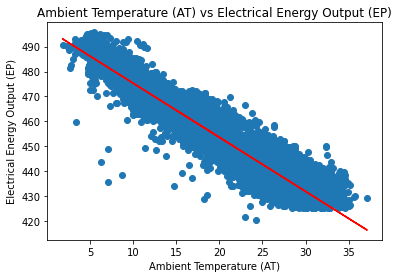

In [10]:
atr = sm.add_constant(at)
regAT = sm.OLS(ep, atr).fit()
print(regAT.summary())

# plot the regression line
ols_regression_plot(at, ep, 'Ambient Temperature (AT)', 'Electrical Energy Output (EP)')

**Exhaust Vacuum**

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                 2.972e+04
Date:                Fri, 23 Sep 2022   Prob (F-statistic):               0.00
Time:                        21:46:37   Log-Likelihood:                -33963.
No. Observations:                9568   AIC:                         6.793e+04
Df Residuals:                    9566   BIC:                         6.794e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        517.8015      0.378   1370.218      0.0

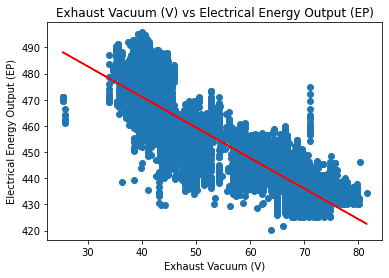

In [11]:
vr = sm.add_constant(v)
regV = sm.OLS(ep, vr).fit()
print(regV.summary())

# Using the table statistics, let us plot the regression (using coefficients pulled from the table)
ols_regression_plot(v, ep, 'Exhaust Vacuum (V)', 'Electrical Energy Output (EP)')

**Ambient Pressure**

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     3516.
Date:                Fri, 23 Sep 2022   Prob (F-statistic):               0.00
Time:                        21:46:41   Log-Likelihood:                -39224.
No. Observations:                9568   AIC:                         7.845e+04
Df Residuals:                    9566   BIC:                         7.847e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1055.2610     25.459    -41.449      0.0

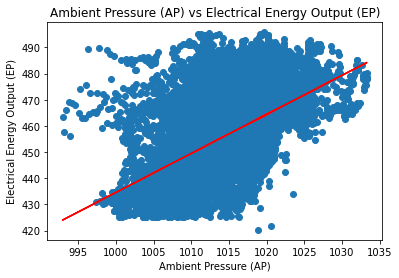

In [12]:
apr = sm.add_constant(ap)
regAP = sm.OLS(ep, apr).fit()
print(regAP.summary())

ols_regression_plot(ap, ep, 'Ambient Pressure (AP)', 'Electrical Energy Output (EP)')

**Relative Humidity**

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     1714.
Date:                Fri, 23 Sep 2022   Prob (F-statistic):               0.00
Time:                        21:46:45   Log-Likelihood:                -39933.
No. Observations:                9568   AIC:                         7.987e+04
Df Residuals:                    9566   BIC:                         7.988e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        420.9618      0.823    511.676      0.0

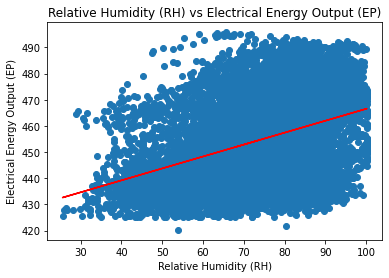

In [13]:
rhr = sm.add_constant(rh)
regRH = sm.OLS(ep, rhr).fit()
print(regRH.summary())

ols_regression_plot(rh, ep, 'Relative Humidity (RH)', 'Electrical Energy Output (EP)')


**Summary**

As we can see from the above summary statistics in each of the regression results tables, the regression for each independent variable returns a p-value of about 0. From this, we can say that each of the independent variables (Ambient Temperature, Exhaust Vacuum, Ambient Pressure, and Relative Humidity) is a statistically significant determinant in predicting the electrical energy output. 
We can see that, in general, the regression line (shown in red) seems to follow the trend of the scatterplot points (shown in blue). For some independent variables, mainly ambient temperature and exhaust vacuum, we can see that our regression is a closer fit to our data points. Alternatively, for Relative Humidity and Ambient Pressure, variables whose data points are more dispersed (scatter plots are more broad), our regression line follows the general trend. 

**Outliers**

Each plot has multiple outlier data points that we should remove from our dataset. Shown below, we have plotted Cook's Distance, a measure of how influential individual data points are. Our data set has 9568 observations. As a general guideline, data points with a cook's distance of greater than 4/n = 4/(9500) should generally be considered potential outliers, though they may need further investigation. In our case, this means data points with a cook's distance of greater than 0.000418 should further considered. As we can see from the following plots, points above the red line should be, according to the cook's distance metric, candidates for further investigation as potential outliers. 

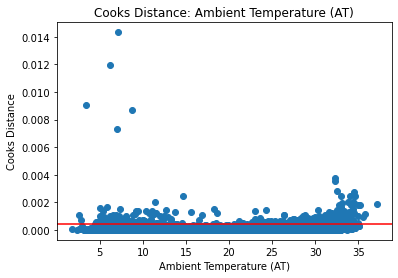

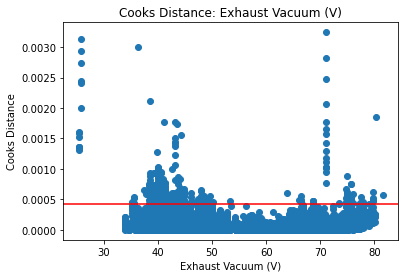

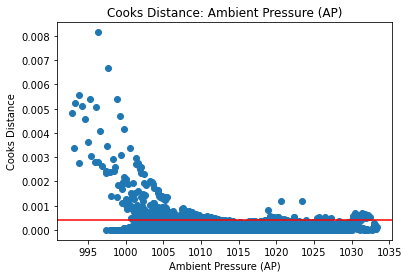

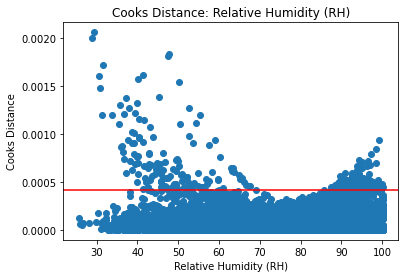

In [14]:
cooks_outlier_plot(regAT, at, 'Ambient Temperature (AT)')
cooks_outlier_plot(regV, v, 'Exhaust Vacuum (V)')
cooks_outlier_plot(regAP, ap, 'Ambient Pressure (AP)')
cooks_outlier_plot(regRH, rh, 'Relative Humidity (RH)')

**D**

In [14]:
x = df[['AmbientTemperature_AT', 'ExhaustVacuum_V', 'AmbientPressure_AP', 'RelativeHumidity_RH']]
y = ep
x = sm.add_constant(x)
reg = sm.OLS(y, x).fit()
print(reg.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Fri, 23 Sep 2022   Prob (F-statistic):               0.00
Time:                        19:16:22   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   454.60

Results: All independent variables are statistically significant in this multiple linear regression. We can see that the p-values for all variables is < 0.001, showing that all the independent variables are extremely statistically significant. We may reject the hypothesis that Bj = 0 for all independent variables and significance levels p = 0.05, 0.025, and 0.001. 

Interpretation: We may **reject** the hypothesis at a 0.05 confidence level that any of these independent variables is **not** a statistically significant determinant of the Electrical Energy Production. 

**E**

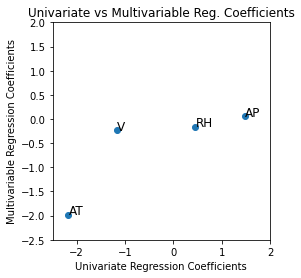

In [15]:
coef_uni = [regAT.params[1],regV.params[1], regAP.params[1], regRH.params[1]]
coef_multi = []
labels = ['AT', 'V', 'AP', 'RH']
for i in reg.params[1:]:
    coef_multi.append(i)
    
plt.scatter(coef_uni, coef_multi)
plt.xlabel('Univariate Regression Coefficients')
plt.ylabel('Multivariable Regression Coefficients')
plt.title('Univariate vs Multivariable Reg. Coefficients')
plt.axis('square')
plt.xlim(left=-2.5, right=2)
plt.ylim(bottom=-2.5, top=2)
for i, txt in enumerate(labels):
    plt.annotate(txt, (coef_uni[i], coef_multi[i]), fontsize=12)
plt.show()


The absolute value of the regression coefficients tends to be higher in the multivariable linear regression than in the univariate linear regression. 

**F**

**Creating Polynomials**

In [16]:
def create_poly(x, y):
    # create polynomial
    poly = PolynomialFeatures(degree=3)
    x_vals = poly.fit_transform(x)
    # then fit model
    reg = sm.OLS(y, x_vals).fit()
    print(reg.summary())

**Ambient Temperature (AT):**

In [17]:
create_poly(at, ep)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                 3.299e+04
Date:                Fri, 23 Sep 2022   Prob (F-statistic):               0.00
Time:                        19:16:33   Log-Likelihood:                -29101.
No. Observations:                9568   AIC:                         5.821e+04
Df Residuals:                    9564   BIC:                         5.824e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        492.7281      0.673    732.248      0.0

**Exhaust Vacuum (V):**

In [18]:
create_poly(v, ep)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                 1.098e+04
Date:                Fri, 23 Sep 2022   Prob (F-statistic):               0.00
Time:                        19:16:37   Log-Likelihood:                -33585.
No. Observations:                9568   AIC:                         6.718e+04
Df Residuals:                    9564   BIC:                         6.721e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        554.1468      9.151     60.557      0.0

**Ambient Pressure (AP):**

In [19]:
create_poly(ap, ep)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     1813.
Date:                Fri, 23 Sep 2022   Prob (F-statistic):               0.00
Time:                        19:16:40   Log-Likelihood:                -39184.
No. Observations:                9568   AIC:                         7.837e+04
Df Residuals:                    9565   BIC:                         7.840e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0747      0.009      8.415      0.0

**Relative Humidity (RH):**

In [20]:
create_poly(rh, ep)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     579.2
Date:                Fri, 23 Sep 2022   Prob (F-statistic):               0.00
Time:                        19:16:42   Log-Likelihood:                -39923.
No. Observations:                9568   AIC:                         7.985e+04
Df Residuals:                    9564   BIC:                         7.988e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        468.4135     10.545     44.422      0.0

**Observations**
There is evidence of non-linear asssociations between each of the independent variables and Electrical Energy Output. We can see this by observing the p-values for each of the independent variables as they are raised to various exponential powers. However, we should note that some of the predictors for the Exhaust Vacuum independent variable do not have a statistically significant association with electrical energy output. We can see this through the p-values for the x^2 and x^3 predictors, which are 0.768 and 0.014, respectively. From this, we can conclude that we are not able to reject the null hypothesis that (Exhaust Vacuum)^2 does not have an impact on electrical energy output (in other words: our hypothesis is such that (exhaust vacuum)^2 does not have an impact on EP. We cannot disprove this statement given our results). Depending on our statistical significance threshold, (exhaust vacuum)^3 can or can not have a statistically significant effect. If our p-value threshold = 0.01, we fail to reject the null hypothesis (that (exhaust vacuum)^3 has no statistically significant effect on electrical energy output). 

**PART G**

In [21]:
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer()

In [22]:
x = df.drop('ElectEnergyOutput_EP', axis=1)
x = x.to_numpy()
poly = PolynomialFeatures(interaction_only=True)
x_vals = poly.fit_transform(x)
reg = sm.OLS(ep, x_vals).fit()
print(reg.summary())
print("\nOrder of Coefficients:")
print(poly.get_feature_names())
print("[const, x1=at, x2=v, x3=ap, x4=rh, x5=atv, x6=atap, x7=atrh, x8=vap, x9=vrh, x10=aprh]")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 1.405e+04
Date:                Fri, 23 Sep 2022   Prob (F-statistic):               0.00
Time:                        19:16:51   Log-Likelihood:                -27548.
No. Observations:                9568   AIC:                         5.512e+04
Df Residuals:                    9557   BIC:                         5.520e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        685.7825     78.640      8.721      0.0

**Observations**
There is evidence of association of interactions of predictors with the response. Note the p-values for x2, x3, x4, x5, x7, x8, and x10, which are all less than 0.05; these terms are all statistically significant at a p-value of 0.05. Of these, x5 (ATV), x7 (ATRH), x8 (VAP), and x10 (APRH) are statistically significant pairwise predictors at a p-value of 0.01. These interaction terms can be converted to their variable names using the 'Order of Coefficients' table above. 

**PART H**

In [23]:
# create training data:
tdf = shuffle(df, random_state=42)
train_data, test_data = train_test_split(tdf, test_size=0.3)

train_x = train_data.drop('ElectEnergyOutput_EP', axis=1)
train_y = train_data['ElectEnergyOutput_EP']

test_x = test_data.drop('ElectEnergyOutput_EP', axis=1)
test_y = test_data['ElectEnergyOutput_EP']

**Training the Models**

In [24]:
# All (linear) Predictors
print("Model A")
x_lin = sm.add_constant(train_x)
reg = sm.OLS(train_y, x_lin).fit()
print(reg.summary())



# reg = LinearRegression()
# reg.fit(train_x, train_y)
# y_predictions = reg.predict(test_x)
print("\n\n\n Model B")

# All linear predictors + significant interaction terms + significant nonlinearities 
poly_comp = PolynomialFeatures()
x_train_np = train_x.to_numpy()
x_train_comp = poly_comp.fit_transform(x_train_np)
reg_comp = sm.OLS(train_y, x_train_comp).fit()
print(reg_comp.summary())

print("\n\nFeatures are organized as follows:", poly_comp.get_feature_names())



Model A
                             OLS Regression Results                             
Dep. Variable:     ElectEnergyOutput_EP   R-squared:                       0.928
Model:                              OLS   Adj. R-squared:                  0.928
Method:                   Least Squares   F-statistic:                 2.155e+04
Date:                  Fri, 23 Sep 2022   Prob (F-statistic):               0.00
Time:                          19:17:03   Log-Likelihood:                -19657.
No. Observations:                  6697   AIC:                         3.932e+04
Df Residuals:                      6692   BIC:                         3.936e+04
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
co

Thus, using our independent variables, variables represent the following features:

**[const, x1=AT, x2=V, x3=AP, x4=RH, x5=AT^2, x6=ATV, x7=ATAP, x8=ATRH, x9=V^2, x10=VAP, x11=VRH, x12=AP^2, x13=APRH, x14=RH^2 ]**

**NOTE** We can see here that vars x1 (AT), x7 (ATAP), x9 (V^2), x10 (VAP), x11 (VRH) have p-values > 0.05. However, we know that variable x5 (AT^2) has a p-values < 0.05, and are significant. Therefore, we should not remove x1  given that its higher powered features are significant. Interaction terms, however, we may remove because they do not have other terms of which depend on them. 

Therefore, we should remove x7, x9, x10, and x11. 


In [25]:
# Features to remove: 
remove = [7, 9, 10, 11]
remove.reverse() # remove bottom to top so indices are not shifted upon removal 
for val in remove:
    x_train_comp = np.delete(x_train_comp, [val], 1)

reg_comp = sm.OLS(train_y, x_train_comp).fit()
print(reg_comp.summary())

                             OLS Regression Results                             
Dep. Variable:     ElectEnergyOutput_EP   R-squared:                       0.937
Model:                              OLS   Adj. R-squared:                  0.937
Method:                   Least Squares   F-statistic:                     9892.
Date:                  Fri, 23 Sep 2022   Prob (F-statistic):               0.00
Time:                          19:19:52   Log-Likelihood:                -19224.
No. Observations:                  6697   AIC:                         3.847e+04
Df Residuals:                      6686   BIC:                         3.855e+04
Df Model:                            10                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.008e+04   1097.478

In [26]:
# Now, our two models are stored in reg and reg_comp
# Next step, text models with training data + find MSE 

# TEST DATA FOR FIRST MODEL
test_x_reg = sm.add_constant(test_x)

# TEST DATA FOR SECOND MODEL
x_test_np = test_x.to_numpy()
x_test_reg_comp = poly_comp.fit_transform(x_test_np)
remove = [7, 9, 10, 11]
remove.reverse() # remove bottom to top so indices are not shifted upon removal 
for val in remove:
    x_test_reg_comp = np.delete(x_test_reg_comp, [val], 1)



# PREDICTION Y VALUES FROM MODELS (TEST SET)
y_test_reg_predict = reg.predict(test_x_reg)
y_test_reg_comp_predict = reg_comp.predict(x_test_reg_comp)

# PREDICTION Y VALUES FROM MODELS (TRAINING SET)
y_train_reg_predict = reg.predict(x_lin)
y_train_reg_comp_predict = reg_comp.predict(x_train_comp)



In [27]:
# Find MSE of models and data 
mse_reg_test = mean_squared_error(y_test_reg_predict, test_y)
mse_reg_train = mean_squared_error(y_train_reg_comp_predict, train_y)
mse_reg_comp_test = mean_squared_error(y_test_reg_comp_predict, test_y)
mse_reg_comp_train = mean_squared_error(y_train_reg_predict, train_y)
print("MSE Results (test and train):")
print("MSE model 1, test data:", mse_reg_test)
print("MSE model 1, train data:", mse_reg_train)
print("MSE model 2, test data:", mse_reg_comp_test)
print("MSE model 2, train data:", mse_reg_comp_train)
print("\n\nAlternate Result Display Order:")
print("Test Data:\nMSE model 1, test data:", mse_reg_test)
print("MSE model 2, test data:", mse_reg_comp_test)
print("Train Data:\nMSE model 1, train data:", mse_reg_train)
print("MSE model 2, train data:", mse_reg_comp_train)

MSE Results (test and train):
MSE model 1, test data: 20.821644558378683
MSE model 1, train data: 18.232969424159023
MSE model 2, test data: 17.950869053624952
MSE model 2, train data: 20.749129456647502


Alternate Result Display Order:
Test Data:
MSE model 1, test data: 20.821644558378683
MSE model 2, test data: 17.950869053624952
Train Data:
MSE model 1, train data: 18.232969424159023
MSE model 2, train data: 20.749129456647502


**OBSERVATIONS** As we can see, our MSE decreased in the second model (with interaction terms + insignificant variables removed) for the test data. For the training data, however, the opposite is true. 

**Part I**

KNN Regression

In [28]:
k_vals = []
for k in range(1, 101):
    k_vals.append(k)
    

In [29]:
# tdf = shuffle(df, random_state=42)

train_data, test_data = train_test_split(tdf, test_size=0.3)

#RAW DATA 
raw_x_train = train_data.drop('ElectEnergyOutput_EP', axis=1)
raw_y_train = train_data['ElectEnergyOutput_EP']

raw_x_test = test_data.drop('ElectEnergyOutput_EP', axis=1)
raw_y_test = test_data['ElectEnergyOutput_EP']

# NORMALIZED DATA
scaler = MinMaxScaler()
model = scaler.fit(raw_x_train)
norm_x_train = model.transform(raw_x_train)
norm_x_test = model.transform(raw_x_test)


In [30]:
test_raw_error = []
test_norm_error = []
train_raw_error = []
train_norm_error = []
mse_reg_test = mean_squared_error(y_test_reg_predict, test_y)


# RAW DATA FIRST 

# TRAINING ERROR 
for k in k_vals:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(raw_x_train, raw_y_train)
    predict = knn.predict(raw_x_train)
    train_raw_error.append(mean_squared_error(predict, raw_y_train))


In [31]:
# TEST ERROR 
for k in k_vals:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(raw_x_train, raw_y_train)
    predict = knn.predict(raw_x_test)
    test_raw_error.append(mean_squared_error(predict, raw_y_test))


In [32]:
# NORMALIZED DATA SECOND 

# TRAINING ERROR 
for k in k_vals:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(norm_x_train, raw_y_train)
    predict = knn.predict(norm_x_train)
    train_norm_error.append(mean_squared_error(predict, raw_y_train))


In [33]:
# TEST ERROR 
for k in k_vals:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(norm_x_train, raw_y_train)
    predict = knn.predict(norm_x_test)
    test_norm_error.append(mean_squared_error(predict, raw_y_test))


In [35]:

print("Min Raw Test Error:", min(test_raw_error), ", k =", test_raw_error.index(min(test_raw_error))+1)
print("Min Raw Train Error:", min(train_raw_error[1:]), ", k =", train_raw_error.index(min(train_raw_error[1:]))+1)
print("Min Normalized Test Error:", min(test_norm_error), ", k =", test_norm_error.index(min(test_norm_error))+1)
print("Min Normalized Train Error:", min(train_norm_error[1:]), ", k =", train_norm_error.index(min(train_norm_error[1:]))+1)

Min Raw Test Error: 16.74300292290723 , k = 6
Min Raw Train Error: 5.41847009855159 , k = 2
Min Normalized Test Error: 14.61426779519331 , k = 5
Min Normalized Train Error: 5.007855636852323 , k = 2


Best fit: when k = 5, data is normalized, the MSE is lowest.  

In [36]:
inv_k = []
for k in k_vals:
    inv_k.append(1/k)
    

**Plotting Raw Test/Training Error**

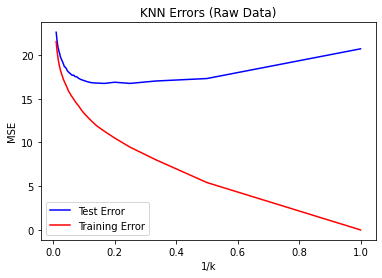

In [37]:
plt.plot(inv_k, test_raw_error, color='blue')
plt.plot(inv_k, train_raw_error, color='red')
plt.xlabel("1/k")
plt.ylabel("MSE")
plt.title("KNN Errors (Raw Data)")
plt.legend(labels=['Test Error', 'Training Error'])

plt.show()

**Plotting Normalized Test/Training Error**

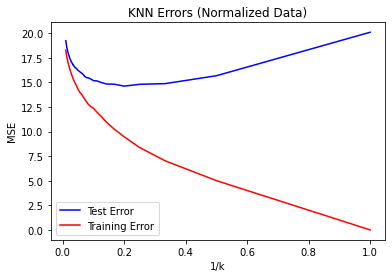

In [38]:
plt.plot(inv_k, test_norm_error, color='blue')
plt.plot(inv_k, train_norm_error, color='red')
plt.xlabel("1/k")
plt.ylabel("MSE")
plt.title("KNN Errors (Normalized Data)")
plt.legend(labels=['Test Error', 'Training Error'])
plt.show()

**PART J**

Observations: 

**Lowest MSE with Linear Regression**: MSE model 2 (multivariable linear regression, removed insignificant features), Test MSE = 19.304770857753745

**Lowest MSE with KNN regression**: Normalized, Test MSE = 13.957824344130966 , k = 5. 

We can see here that a KNN regression returns a smaller MSE than the Linear Regression model, even when the OLS model is a multivariable lienar regression with insignificant features removed. This may be because linear regressions in general assume a direct form for our data. Even with multivariable features, interaction terms, and polynomial features, we are still creating a general shape that we believe our data will follow, and this may oversimplify the spread of the data, and simplify our predictions. 

Alternatively, KNN regression offers a bit more flexibility in predictions, and doesn't assume the same stiff shape of linear regressions. This may make it a better fit for more complex models, as we are not assuming it follows some linear path. This is likely why the MSE is lower for KNN regression than our Multivariate Linear Regression. 




**ISLR Questions**

**2.4.1**

**a)**
Flexible model would be better than an inflexible model in this scenario. Since we don't have many predictors but we do have a large sample size, it would be advantageous to allow the flexible model to follow the data naturally for a closer fit. Our large sample size will help limit overfitting. 

**b)** 
Flexible model would be worse than an inflexible model. We have a limited sample of data, so it is better to follow our various predictors for a more accurate fit. Using a flexible model may result in overfitting. 

**c)**
Flexible model would be better. Using an inflexible model will confine the model to a specific shape, and if the data is very nonlinear, an inflexible model would not be idea. A flexible model, without distinct shape, would be a better fit in this case. 

**d)**
Flexible model would be worse. There's a higher chance of overfitting when using a flexible model when the variance is high. We would be fitting to the error if we used a flexible model, which is not ideal. Use an inflexible model instead. 

**2.4.7**


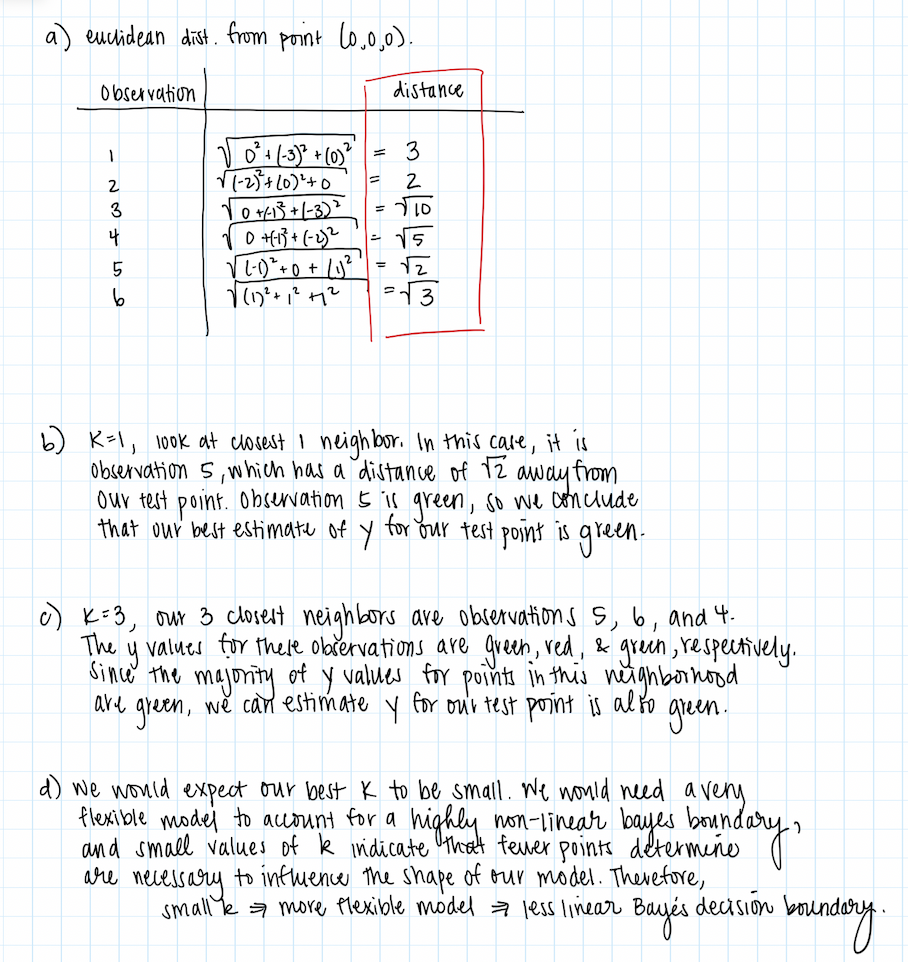